In [1]:
import sys
import torch
import random
import numpy as np
from torch import nn
from icecream import ic
from torch.optim import Adam
from torchinfo import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torch.optim import lr_scheduler
from torch.utils.data import Dataset

# from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset, random_split


# -------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(str(device))

N = 4  # number of images in whole picture
L_x = 5  # x and y pixel dims
L_y = 5
N_i = L_x * L_y
N_h = 256
N_o = 1


class IonImagesDataset(Dataset):
    def __init__(self, file_path):
        loaded_data_dict = torch.load(file_path)  # loading dataset into dataloader

        self.images = loaded_data_dict[
            "images"
        ]  # creating of 2 datasents of imgages and keys to them
        self.labels = loaded_data_dict["labels"]

    def __len__(self):
        return len(self.images)  # just return len function

    def __getitem__(self, idx):
        image_tensor = self.images[idx]  # Add a channel dimension
        label_tensor = self.labels[idx]  # Repeat the label for each ion position
        return image_tensor, label_tensor


file_path_pt = "labels_and_images.pt"


dataset = IonImagesDataset(file_path_pt)
halfpi_dataset = IonImagesDataset(file_path_pt)

# Split the dataset into training and validation subsets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
print(
    f"Train size: {train_size}, Validation size: {val_size}"
)  # Print the sizes of subsets

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(
    f"Train dataset size: {len(train_dataset)}"
)  # Print the size of the train_dataset
print(
    f"Validation dataset size: {len(val_dataset)}"
)  # Print the size of the val_dataset

# Create DataLoaders for the training and validation datasets
batch_size = min(1000, len(train_dataset))  # or choose a smaller value
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)

halfpi_loader = DataLoader(
    halfpi_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)


class IndexDependentDense(nn.Module):
    def __init__(self, N, N_i, N_o, activation=nn.ReLU()):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o
        self.activation = activation
        self.register_parameter(
            "W", nn.Parameter(torch.empty(self.N, self.N_i, self.N_o))
        )
        self.register_parameter("b", nn.Parameter(torch.empty(self.N, self.N_o)))

        self._reset_parameters()

        pass

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.W)
        nn.init.zeros_(self.b)

    def forward(self, x):
        y = torch.einsum("nij,...ni->...nj", self.W, x) + self.b
        if self.activation is not None:
            return self.activation(y)
        else:
            return y

    pass


# ---------------------------------------------------------------------------------------------


class Encoder(nn.Module):
    def __init__(self, N, N_i, N_o):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o

        self.dense = IndexDependentDense(N, N_i, N_o, activation=nn.ReLU())
        pass

    def forward(self, x):
        y = self.dense(x)
        return y

    pass


# ---------------------------------------------------------------------------------------------


class Classifier(nn.Module):
    def __init__(self, N, N_i, N_o):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o
        self.dense = IndexDependentDense(N, N_i, N_o, activation=None)
        pass

    def forward(self, x):
        y = self.dense(x)
        y = torch.sigmoid(y)  # Apply sigmoid activation here
        return y

    pass


# ---------------------------------------------------------------------------------------------


class SharedEncoder(nn.Module):
    def __init__(self, N, N_i, N_o):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o

        self.dense = nn.Linear(N_i, N_o)
        pass

    def forward(self, x):
        y = self.dense(x)
        return y

    pass


# ---------------------------------------------------------------------------------------------


class MultiIonReadout(nn.Module):
    def __init__(self, encoder, shared_encoder, classifier):
        super().__init__()

        self.encoder = encoder
        self.shared_encoder = shared_encoder
        self.classifier = classifier

    def forward(self, x):
        y = x.reshape(*x.shape[:-2], -1).to(torch.float32)
        y1 = self.encoder(y)
        y2 = self.shared_encoder(y)
        y_concat = torch.cat([y1, y2], dim=-1)
        y = self.classifier(y_concat)
        return y

    def bceloss(self, X, y):
        return F.binary_cross_entropy(self(X), y)

    @staticmethod
    def _accuracy(y_pred, y_true):
        mod_y_pred = (y_pred > 0.5).to(torch.float32)
        accuracy = (y_true == mod_y_pred).to(dtype=torch.float32).mean()
        return accuracy * 100

    def accuracy(self, x, y):
        return self._accuracy(self(x), y)


# ---------------------------------------------------------------------------------------------

cpu


FileNotFoundError: [Errno 2] No such file or directory: 'labels_and_images.pt'

In [2]:
device = torch.device("cpu")

encoder = Encoder(N, N_i, N_h)
shared_encoder = SharedEncoder(N, N_i, N_h)
classifier = Classifier(N, N_h * 2, N_o)
model = MultiIonReadout(encoder, shared_encoder, classifier)


model = model.to(device)
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params2 = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)
print(pytorch_total_params2)
# # Create a SummaryWriter
# writer = SummaryWriter('runs/ion_images_experiment')

# # Log model architecture (Optional)
# images, _ = next(iter(train_loader))
# writer.add_graph(model, images)

N_epochs = 100
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
schedule_params = {"factor": 1}
schedule = lr_scheduler.ConstantLR(optimizer, **schedule_params)
log_every = 1

# Training loop
for epoch in range(N_epochs):

    total_train_loss = 0
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = model.bceloss(inputs, labels)
        loss.backward()
        optimizer.step()

        # total_train_loss += loss.item()

    # avg_train_loss = total_train_loss / len(train_loader)

    sys.stdout.flush()
    # writer.add_scalar('Training Loss', avg_train_loss, epoch)

    # Evaluation loop
    with torch.no_grad():
        total_loss = 0
        total_accuracy = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            loss = model.bceloss(inputs, labels)
            accuracy = model.accuracy(inputs, labels)
            total_loss += loss.item()
            total_accuracy += accuracy.item()

        avg_loss = total_loss / len(val_loader)
        avg_accuracy = total_accuracy / len(val_loader)
        # writer.add_scalar('Validation Loss', avg_loss, epoch)
        # writer.add_scalar('Validation Accuracy', avg_accuracy, epoch)

    print(
        "\r Epoch {}/{}, Training Loss = {}, Val Loss = {}, Val Acc = {}".format(
            epoch + 1, N_epochs, loss.item(), avg_loss, avg_accuracy
        ),
        end="",
    )

torch.save(model.state_dict(), "golden_WandB_n.pth")
# Close the writer
# writer.close()

35332
35332
 Epoch 100/100, Training Loss = 0.2069842368364334, Val Loss = 0.22685407102108002, Val Acc = 91.86249923706055

ic| uniform_counts: [0.0625,
                     0.0625,
                     0.0625,
                     0.0625,
                     0.0625,
                     0.0625,
                     0.0625,
                     0.0625,
                     0.0625,
                     0.0625,
                     0.0625,
                     0.0625,
                     0.0625,
                     0.0625,
                     0.0625,
                     0.0625]
ic| normalized_counts: [0.0609,
                        0.0608,
                        0.0526,
                        0.0674,
                        0.0576,
                        0.0695,
                        0.065,
                        0.0797,
                        0.0595,
                        0.0639,
                        0.0639,
                        0.0692,
                        0.0547,
                        0.0513,
                        0.0661,
                        0.0579]
ic| f"Root mean squared e

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, '[[1.0], [1.0], [1.0], [1.0]]'),
  Text(1, 0, '[[1.0], [0.0], [1.0], [1.0]]'),
  Text(2, 0, '[[0.0], [1.0], [1.0], [1.0]]'),
  Text(3, 0, '[[1.0], [1.0], [0.0], [1.0]]'),
  Text(4, 0, '[[1.0], [1.0], [1.0], [0.0]]'),
  Text(5, 0, '[[1.0], [0.0], [1.0], [0.0]]'),
  Text(6, 0, '[[0.0], [1.0], [0.0], [1.0]]'),
  Text(7, 0, '[[0.0], [0.0], [1.0], [1.0]]'),
  Text(8, 0, '[[1.0], [1.0], [0.0], [0.0]]'),
  Text(9, 0, '[[0.0], [1.0], [1.0], [0.0]]'),
  Text(10, 0, '[[1.0], [0.0], [0.0], [1.0]]'),
  Text(11, 0, '[[0.0], [0.0], [1.0], [0.0]]'),
  Text(12, 0, '[[0.0], [0.0], [0.0], [1.0]]'),
  Text(13, 0, '[[0.0], [1.0], [0.0], [0.0]]'),
  Text(14, 0, '[[1.0], [0.0], [0.0], [0.0]]'),
  Text(15, 0, '[[0.0], [0.0], [0.0], [0.0]]')])

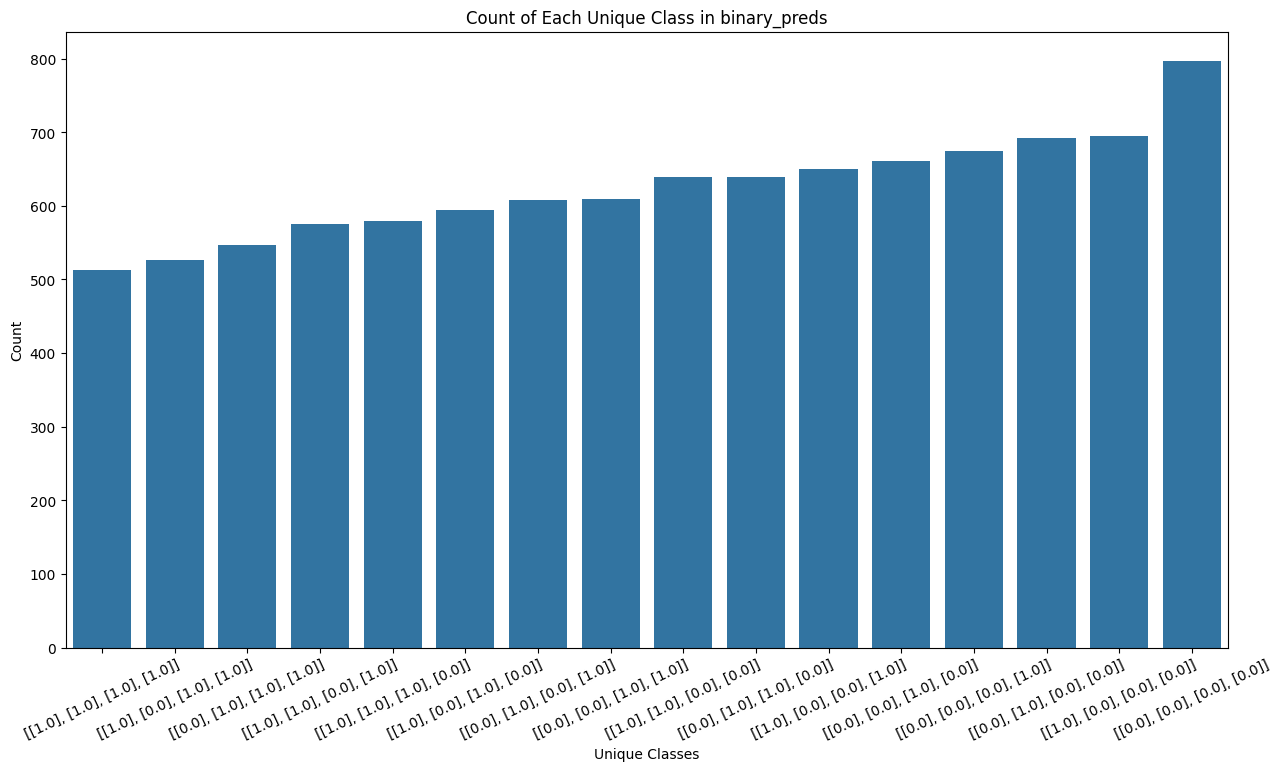

In [3]:
from collections import Counter
from math import sqrt
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from icecream import ic

preds = []

for inputs, labels in halfpi_loader:

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    preds.append(model.forward(inputs))

preds = [b for i in preds for b in i]

# Make the tensor values binary for each tensor in the list
binary_preds = [(pred > 0.5).float() for pred in preds]


# Convert each tensor to a string and count occurrences
tensor_str_counts = Counter([str(tensor.tolist()) for tensor in binary_preds])

# Prepare data for plotting
labels = [label for label in tensor_str_counts.keys()]
counts = [count for count in tensor_str_counts.values()]
# print(labels)
# print(counts)
################################################################################
normalized_counts = [x / 10000 for x in counts]
uniform_counts = [1 / len(labels) for _ in labels]
ic(uniform_counts)
ic(normalized_counts)

# Calculate the root mean squared error
loss = sqrt(mean_squared_error(normalized_counts, uniform_counts))
ic(f"Root mean squared error: {loss}")
################################################################################

# Sort by counts
sorted_labels, sorted_counts = zip(*sorted(zip(labels, counts), key=lambda x: x[1]))

# Convert tuples to lists
sorted_labels = list(sorted_labels)
sorted_counts = list(sorted_counts)

# Create the countplot
plt.figure(figsize=(15, 8))
sns.barplot(x=sorted_labels, y=sorted_counts)

plt.title("Count of Each Unique Class in binary_preds")
plt.xlabel("Unique Classes")
plt.ylabel("Count")
plt.xticks(rotation=25)
# plt.savefig('sorted_results.png')
# plt.show()

# Old code


In [4]:
# ion_positions=[0, 1, 2, 3]
# images = []
# categories = []
# labels = ["dark", "bright"]
# file_paths = [file_path_dark, file_path_bright]

# for file_path, label in zip(file_paths, labels):
#     with h5py.File(file_path, "r") as f:
#         print(f"h5 file has {len(f.keys())} keys.")  # Print the number of keys
# #                 print(f"h5 file has {f.keys()} keys.")
# #
#         # # Get the unique image numbers from the keys
#         # image_numbers = [int(re.search(r'(\d+)_ion_0', key).group(1)) for key in f.keys()]

#         image_number = 0
#         # while image_number<100:
#         while True:
#             try:
#                 image_tensors = []
#                 for ion_position in ion_positions:
#                     key = f"{label}_{image_number}_ion_{ion_position}"
#                     ion_image = np.array(f[key])  # Load data as a numpy array
#                     ion_image_tensor = torch.tensor(ion_image, dtype=torch.float32).view(L_x, L_y) -200  # Reshape the tensor
#                     image_tensors.append(ion_image_tensor)

#                 # Concatenate the image tensors for all ion positions
#                 combined_image_tensor = torch.stack(image_tensors)
#                 images.append(combined_image_tensor[None,...])
#                 categories.append(torch.tensor([0,0,0,0],dtype=torch.float32)[:,None] if label == "dark" else torch.tensor([1,1,1,1],dtype=torch.float32)[:,None])

#                 image_number += 1
#             except:
#                 break

In [5]:
# import torch
# import itertools
# import random

# # Function to swap slices based on label values
# def swap_slices(categories, images):
#     for i in range(4):  # Loop over each position in the tensor
#         # Find tensors that have 1 at the i-th position
#         ones_indices = [idx for idx, cat in enumerate(categories) if cat[i] == 1]

#         # Find tensors that have 0 at the i-th position
#         zeros_indices = [idx for idx, cat in enumerate(categories) if cat[i] == 0]

#         # Randomly select half from the ones_indices
#         ones_to_swap = random.sample(ones_indices, len(ones_indices) // 2)

#         # Randomly select the same number from the zeros_indices
#         zeros_to_swap = random.sample(zeros_indices, len(ones_to_swap))

#         # Perform the swap
#         for one, zero in zip(ones_to_swap, zeros_to_swap):
#             images[one][0, i], images[zero][0, i] = images[zero][0, i].clone(), images[one][0, i].clone()

#             # Also swap the corresponding labels
#             categories[one][i], categories[zero][i] = categories[zero][i], categories[one][i]

# swap_slices(categories, images)

In [6]:
# new_categories = []
# new_images = []
# remove_count = 10_000
# for cat, img in zip(categories, images):
#     if str(cat.tolist()) == '[[0.0], [0.0], [0.0], [0.0]]':
#         if remove_count > 0:
#             remove_count -= 1
#             continue
#     new_categories.append(cat)
#     new_images.append(img)

In [7]:
# Counter([str(tensor.tolist()) for tensor in new_categories])

In [8]:
# images = torch.concat(new_images,dim=0)
# labels = torch.stack(new_categories)

In [9]:
# # Create a dictionary to hold both tensors
# data_dict = {
#     'labels': labels,
#     'images': images
# }

# # Save the dictionary as a .pt file
# torch.save(data_dict, 'labels_and_images.pt')